In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure
import cv2
from math import pi, ceil, floor, cos, sin
import os
import time
from ipynb.fs.full.unet_mask import *

plt.rcParams["figure.figsize"] = (10, 10)
# kill axis in rcParams
plt.rc('axes.spines',top=False,bottom=False,left=False,right=False);
plt.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
plt.rc(('xtick','ytick'),color=(1,1,1,0));

#PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
#PATH = "./samples/normal/blood_smear_2.JPG"
PATH = "./samples/normal/blood_smear_1.JPG"
#PATH = "./samples/aglomerado/blood_smear_14.JPG"
RESULT_PATH = "./samples/myresults/"
#PATH = "DSCN4223.JPG"

CELL_POINT_SIZE = 8
CELL_COLOR      = (255,60,0)
INTERNAL_COLOR  = (215,215,20)
EXTERNAL_COLOR  = (255, 255, 255)



# General functions

In [2]:
def save_results(image_name, method_name, cells,internalInfection,externalInfection, passTime, img, path, method_ext):
    
    #save png
    out_path = "./samples/segmented/"
    if os.path.exists(out_path) == False:
        os.mkdir(out_path)
    name = path.split("/")[-1]
    out = out_path + name.lower().replace(".jpg",method_ext) + ".png"
    plt.imsave(out,img,format='png')
    
    
    
    #save txt
    image_name_parts = image_name.split("/")
    image_name = image_name_parts[-1]
    image_name = image_name.lower().replace(".jpg","")
    f_name = RESULT_PATH + image_name + "_result.txt"
    
    if os.path.exists(RESULT_PATH) == False:
        os.mkdir(RESULT_PATH)
    
    if os.path.exists(f_name):
        f = open(f_name,"r+")
        
        lines = f.read().split("\n")
        for l in range(len(lines)):
            line = lines[l]
            if line.startswith(method_name):
                lines[l] = f"{method_name:20}\t{cells:7}\t{internalInfection:8}\t{externalInfection:8}\t{passTime:6}\t{out}"
                txt = "\n".join(lines)
                
                f.truncate(0)
                f.seek(0)
                f.write(txt)
                f.close()
                return
    else:
        f = open(f_name,"w")
        f.write(f"{'METHOD':20}\t{'  CELLS':7}\t{'INTERNAL':8}\t{'EXTERNAL':8}\t{'TIME':6}\tFILE_NAME\n")
    f.write(f"{method_name:20}\t{cells:7}\t{internalInfection:8}\t{externalInfection:8}\t{passTime:6}\t{out}\n")
    f.close()
    
#save_results("b","teste1",1,2,3,'5.5s')
    

In [3]:



def get_image(path=PATH, mode=0, size=(640,480), show=False):
    img = cv2.imread(path,mode)
    if mode == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is None:
        print("Não foi possível abrir a imagem:", path)
    res = cv2.resize(img,size)
    
    if show:
        plt.figure(figsize=(10,10))
        plt.imshow(res)
        plt.show()
    return res

    

def apply_blur(img, k=9):
    return cv2.GaussianBlur(img,(k,k),0)

def otsu(img,block=81,offset=0.3):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def adaptative_thresh(img,block=121,offset=0):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def fill_holes(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    thresh_filled = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    color = 255
    for i in range(len(contours)):
        cv2.drawContours(thresh_filled, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    return thresh_filled

def connected_components(thresh):
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    if (np.max(labels) == 0):
        divider = 1
    else:
        divider = np.max(labels)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/divider)
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    labeled_img_rgb = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
    return labeled_img_rgb, numLabels, labels, stats, centroids


def erode(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.erode(src, element)
    
def dilate(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.dilate(src, element)

def get_principal_components(img):
    # Connected components with stats.
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)
    
    max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])
    
    img2 = np.zeros(output.shape, dtype='uint8')
    img2[output == max_label] = 255
    return img2

def get_principal_component_RGB(img,mask):
    mask = get_principal_components(mask)
    new = np.zeros(img.shape, dtype='uint8')
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y] == 255:
                new[x,y] = img[x,y]
    return new

def color_average(img):
    lista = img.reshape(img.shape[0]*img.shape[1],3)
    lista = lista[lista != [0,0,0]]
    lista = lista.reshape(len(lista)//3,3)
    avg = lista.mean(axis=0)
    avg = np.uint8(avg)
    median = np.median(lista, axis=0)
    return avg, median

def hsv_average(img):
    hues = []
    lista = img.reshape(img.shape[0]*img.shape[1],3)
    for i in range(0,len(lista),3):
        if lista[i][0] != 0:
            hues.append(lista[i][0])
    avg = int(np.mean(hues))
    median = int(np.median(hues))
    return avg, median

def color_distance(rgb1, rgb2):
        rm = 0.5 * (rgb1[0] + rgb2[0])
        rd = ((2 + rm) * (rgb1[0] - rgb2[0])) ** 2
        gd = (4 * (rgb1[1] - rgb2[1])) ** 2
        bd = ((3 - rm) * (rgb1[2] - rgb2[2])) ** 2
        return (rd + gd + bd) ** 0.5

In [4]:
MIN_CELL_AREA = 500
MAX_CELL_AREA = 2700#2300
MIN_VALUE_TO_VALIDATE_CELL = 50

def thresh_is_valid(thresh_validation,x,y,w,h):
    
    
    cut = thresh_validation[y:y+h,x:x+w]
    if np.sum(cut) == 0:
        return False
    #pega apenas o maior componente do corte
    #cut = get_principal_components(cut)
    
#     if np.sum(cut)/(cut.shape[0]*cut.shape[1]) <= MIN_VALUE_TO_VALIDATE_CELL:
#         print(np.sum(cut)/(cut.shape[0]*cut.shape[1]))
#         plt.imshow(cut)
#         plt.show()
    value = np.sum(cut)/(cut.shape[0]*cut.shape[1])
    #print (value)
    return value > MIN_VALUE_TO_VALIDATE_CELL


# def equalize_images(img,sTo=80, vTo=150):
#     img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

#     H, S, V = cv2.split(img_hsv)

#     dec = (sTo - np.median(S)).astype('int16')
#     S = S + dec
#     S = S.astype('uint8')

#     dec = (vTo - np.median(V)).astype('int16')
#     V = V + dec
#     V = V.astype('uint8')

#     hsv = cv2.merge([H, S, V])
#     rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

#     return rgb

unet = UNetPredict()
def unet_validation_mask(img):
    mask = unet.predict(img)
    return mask



def equalize_images(img,sTo=80, vTo=150):
    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    H, S, V = cv2.split(img_hsv)

    dec = (sTo - np.median(S)).astype('int16')
    S = S + dec
    S = S.astype('uint8')

    dec = (vTo - np.median(V)).astype('int16')
    V = V + dec
    V = V.astype('uint8')

    hsv = cv2.merge([H, S, V])
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

def hsv_validation_mask(img):

    img = equalize_images(img, sTo=80, vTo=150)

    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (10,70,0), (20,100,150))

    mask = cv2.medianBlur(mask,5)
    mask = dilate(mask,1)
    mask = fill_holes(mask)
    return mask


def cut_circle(img,pos,radius):
    mask = np.zeros((img.shape[0],img.shape[1]))
    cv2.circle(mask, pos, radius, 1, -1)
    new = np.zeros(img.shape, dtype='uint8')
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y] > 0:
                new[x,y] = img[x,y]
    return new



def mark_cells(img, mask, components = None, validation_step = True, estimate = True, validation_type='unet'):
    
    if validation_step:
        if validation_type == 'unet':
            thresh_validation = unet_validation_mask(img)
        elif validation_type == 'hsv':
            thresh_validation = hsv_validation_mask(img)
        else:
            print("Invalid validation_type")
    
    #plt.imshow(thresh_validation)
    #plt.show()
    
    groupColor = 45
    
    #font = img.copy()
    if components == None:
        labeled_img_rgb, numLabels, labels, stats, centroids = connected_components(mask)
        #o primeiro componente é o fundo, deve ser ignorado sempre
        start = 1
    else:
        labeled_img_rgb, numLabels, labels, stats, centroids = components
        
        start = 0
    
    cellsCount = 0

    for i in range(start, numLabels):
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        #get area
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        
        #print(minArea, area, maxArea) minArea=MIN_CELL_AREA, maxArea=MAX_CELL_AREA
        if MIN_CELL_AREA < area < MAX_CELL_AREA or estimate == False:
            cellsCount += 1
            
            #print(cellsCount,end=" ")
            
            if validation_step and thresh_is_valid(thresh_validation,x,y,w,h) == False:
                continue
            
            pos = (int(cX), int(cY))
            
            cv2.circle(img, pos, CELL_POINT_SIZE, (0,0,0), -1)
            cv2.circle(img, pos, CELL_POINT_SIZE-1, CELL_COLOR, -1)            
            cv2.putText(img, str(cellsCount), (int(cX), int(cY)+CELL_POINT_SIZE+10), cv2.FONT_HERSHEY_SIMPLEX,
                        .4, (0,0,0),       1, cv2.LINE_AA)
            
            
            
        
        
        if MAX_CELL_AREA < area and estimate == True:
            
            if validation_step and thresh_is_valid(thresh_validation,x,y,w,h) == False:
                continue
            
            groupColor += 5
            
            #estima quantas celulas no grupo
            est = ceil(area/MAX_CELL_AREA)
            
            #imprime os marcadores de celulas dentro dos grupos
            #em colunas
            if w > 220:
                cols = 8
                margin = 40
            elif w > 120:
                cols = 6
                margin = 20
            else:
                cols = 3
                margin = 10
            xCell = x + margin
            yCell = y + 40
            for i in range(1,est+1):
                cv2.circle(img, (xCell, yCell), CELL_POINT_SIZE-1, (groupColor,0,groupColor), -1)
                xCell += CELL_POINT_SIZE + 10
                
                if i % cols == 0:
                    xCell = x + margin
                    yCell += CELL_POINT_SIZE + 10
            
            #imprime a id das celulas do grupo
            txt = "("+(",".join([str(q) for q in range(cellsCount+1,cellsCount+est+1,1)]))+")"
            
            cv2.putText(img, txt, (x+margin-10, y+20), cv2.FONT_HERSHEY_SIMPLEX,
                        .4, (0,0,0),       1, cv2.LINE_AA)
            cellsCount += est
            
            cv2.rectangle(img, (x,y), (x+w,y+h), (groupColor+2,0,groupColor+2), 2)
            
 
    return img, cellsCount

def break_big_groups(mask,_erode=15,_dilate=11):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connected_components(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        cut = cut.copy()

        if MAX_CELL_AREA < area:
            cut_bk = cut.copy()
            cut = get_principal_components(cut)

            #remove the group from original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask[ cell_on_original_size == 255 ] = 0

            #work on group
            #cut = cv2.erode(cut, kernel, iterations=1)
            cut = erode(cut,_erode)
            cut = dilate(cut,_dilate)

            #return the eroded and marked group to original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask += cell_on_original_size
    
    return mask


# Colors functions

In [5]:
def random_color():
    color = tuple(np.random.randint(1,256, size=3))
    if (color[0] < 100 and color[1] < 100 and color[2] < 100):
        return random_color()
    elif (color[0] > 230 and color[1] > 230 and color[2] > 230):
        return random_color()
    else:
        return (int(color[0]),int(color[1]),int(color[2]))
    

def list_colors(img):
    shape = img.shape
    if (len(shape) == 2):
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    reshapedImg = img.reshape(1,shape[0]*shape[1],3)[0]
    colors = np.unique(reshapedImg, axis=0)
    colors = np.delete(colors,0,axis=0)
    return colors


def shuffle_colors(img):
    
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])

    colors = list_colors(img)
    labeled_img_rgb3 = img.copy()

    for color in colors:
        newColor = random_color()

        red, green, blue = labeled_img_rgb3.T 
        selected_color = (red == color[0]) & (green == color[1]) & (blue == color[2])
        labeled_img_rgb3[selected_color.T] = newColor
    return labeled_img_rgb3


def colorize(img):
    labeled_rgb, numLabels, labels, stats, centroids = connected_components(img)
    return shuffle_colors(labeled_rgb)

def equalize_color_image(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]

# Parasites functions

In [6]:

def hsv_par_mask(img):
    
    #range 1
    from_color=(95,40,0)
    to_color=(180,255,255)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, from_color, to_color)
    
    #range 2
#     from_color=(0,70,85)
#     to_color=(15,75,105)
    
#     mask2 = cv2.inRange(hsv, from_color, to_color)
    
    
#     mask = np.zeros(img.shape)
#     mask = cv2.bitwise_or(mask1,mask2)
    
    #mask = mask_conditional_blur(mask,3,3)
    #mask = mask_conditional_blur(mask,30,40)
    #mask = cv2.inRange(hsv, from_color, to_color)
    mask_dilated = mask.copy()
    #erode
    kernel = np.ones((3, 3), np.uint8)
    mask_dilated = cv2.erode(mask_dilated, kernel)
    #dilate
    kernel = np.ones((15, 15), np.uint8)
    mask_dilated = cv2.dilate(mask_dilated, kernel)

    return mask, mask_dilated


def gs_parasite_mask(gsImg):
    if (len(gsImg.shape) == 3):
        gsImg = cv2.cvtColor(gsImg,cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gsImg, 75, 1, cv2.THRESH_BINARY_INV)
    return thresh

def remove_parasites(img,mask):
    maximum = np.max(mask)
    if maximum == 0:
        return img
    img[mask == maximum] = 0
    img = erode(img,2)
    img = dilate(img,2)
    return img

MIN_PARASITE_AREA = 20


def mark_parasites(img, parasite_mask, cell_mask, cell_components = None, contact_percent=0.15):
    
    
    labeled_rgb, numLabels, labels, stats, centroids = connected_components(parasite_mask)
    
    if cell_components is None:
        _, _, _, cell_stats, _ = connected_components(cell_mask)
    else:
        cell_mask = cv2.cvtColor(cell_components[0],cv2.COLOR_RGB2GRAY)
        cell_stats = cell_components[3]
    
    internal_count = 0
    external_count = 0
    
    
    for i in range(1, numLabels):
        area = stats[i, cv2.CC_STAT_AREA]
        #se for apenas pequenos pontos nao conta
        if MIN_PARASITE_AREA > area:
            continue
        
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        (cX, cY) = centroids[i]
        
        color = EXTERNAL_COLOR
        c = 0
        for cell_stat in cell_stats:
            c += 1
            cellArea  = cell_stat[cv2.CC_STAT_AREA]
            cellX = cell_stat[cv2.CC_STAT_LEFT]
            cellY = cell_stat[cv2.CC_STAT_TOP]
            cellW = cell_stat[cv2.CC_STAT_WIDTH]
            cellH = cell_stat[cv2.CC_STAT_HEIGHT]
            
            if MIN_CELL_AREA < cellArea < MAX_CELL_AREA*10:
                #faz um recorte da celula e do parasita
                cell_cut                                       = np.zeros(parasite_mask.shape)
                cell_cut[cellY:cellY+cellW, cellX:cellX+cellH] = cell_mask[cellY:cellY+cellW, cellX:cellX+cellH]
                par_cut                = np.zeros(parasite_mask.shape)
                par_cut[y:y+h, x:x+w]  = parasite_mask[y:y+h, x:x+w]
                
                
                #verifica a superficie em contato
                contact = np.zeros(cell_cut.shape)
                contact[cv2.bitwise_and(cell_cut,par_cut) > 0] = 1
                contact_percent_calc = np.sum(contact) / area

                #se atingir o minimo esperado, classifica interno
                if contact_percent_calc >= contact_percent:
                    color = INTERNAL_COLOR
                    cv2.rectangle(img, (cellX-1,cellY-1), (cellX+cellW+2,cellY+cellH+2), (0,255,0), 1)
                    cv2.circle(img, (int(cX),int(cY)), 5, (240,240,0),-1)
                    break
        
        if color == INTERNAL_COLOR:
            internal_count += 1
        else:
            external_count += 1
        #caso nao esteja em contato com nenhuma celula, é externo
        cv2.rectangle(img, (x-1,y-1), (x+w+2,y+h+2), color, 1)
        
    return img, internal_count, external_count


# img = get_image(mode=1)
# par_mask = gs_parasite_mask(imgGS)
# img, internal, external = mark_parasites(img, par_mask, cell_mask)
# plt.imshow(img)
# plt.show()

# Thresholding


## UNet

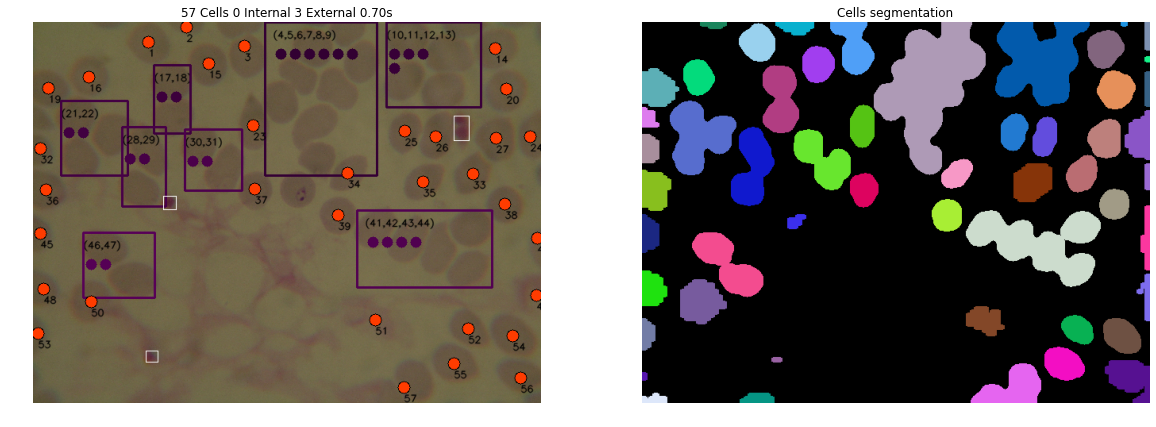

In [8]:

def unet_method(path, validation_type):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)

    #apply blur
    name = "U-net"
    method_ext = "_unet"
        
    
    cell_mask = unet.predict(img)
    
    #hsv mask
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #GS mask
    #par_mask = gs_parasite_mask(imgGS)
    #plt.imshow(par_mask)
    #plt.show()
        
    
    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    

    #fill holes
    cell_mask = fill_holes(cell_mask)
    
    

    #break gorup of cells
    cell_mask = break_big_groups(cell_mask)
    
    
    #colorize the cells
    cell_mask_colored = colorize(cell_mask)
    

    #mark
    if validation_type == 'unet':
        img, cells = mark_cells(img, cell_mask,validation_step=False)
    else:
        img, cells = mark_cells(img, cell_mask,validation_type=validation_type)
    
    img, internal, external = mark_parasites(img, par_mask, cell_mask)

    end = time.time()


    passTime = "%.2fs" % (end-start)

    #save results
    save_results(path,name,cells,internal,external, passTime, img, path, method_ext)
    
    return (img, cell_mask_colored), (cells, internal, external, passTime)


if __name__ == '__main__':
    PATH = './samples/normal/blood_smear_3.JPG'
    images, stats = unet_method(PATH, 'hsv')
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

## OTSU

In [ ]:

def otsu_method(path, validation_type, blur=True):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)

    #apply blur
    name = "OTSU w/out blur"
    method_ext = "_otsu_out_blur"
    if blur:
        name = "OTSU"
        method_ext = "_otsu"
        imgGS = apply_blur(imgGS)
        img = apply_blur(img)
        
    
    
    #otsu adaptative
    cell_mask = otsu(imgGS)
    #cell_mask = unet.predict(img)
    
    
    
    #hsv mask
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #GS mask
    #par_mask = gs_parasite_mask(imgGS)
    #plt.imshow(par_mask)
    #plt.show()
        
    
    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    

    #fill holes
    cell_mask = fill_holes(cell_mask)
    
    

    #break gorup of cells
    cell_mask = break_big_groups(cell_mask)
    
    
    #colorize the cells
    cell_mask_colored = colorize(cell_mask)
    

    #mark
    img, cells = mark_cells(img, cell_mask,validation_type=validation_type)
    
    img, internal, external = mark_parasites(img, par_mask, cell_mask)

    end = time.time()


    passTime = "%.2fs" % (end-start)

    #save results
    save_results(path,name,cells,internal,external, passTime, img, path, method_ext)
    
    return (img, cell_mask_colored), (cells, internal, external, passTime)


if __name__ == '__main__':
    PATH = './samples/normal/blood_smear_3.JPG'
    images, stats = otsu_method(PATH, 'unet')
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

## OTSU without blur

In [ ]:
if __name__ == '__main__':

    images, stats = otsu_method(PATH, 'unet', blur=False)
    img, cell_mask = images
    cells, internal, external, passTime = stats 

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()


# HSV

In [ ]:
def cellHSVMask(img, from_color=(0,170,0),to_color=(20,255,220)):
#def cellHSVMask(img, from_color=(0,80,0),to_color=(20,255,255)):
    img = equalize_color_image(img)
    
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, from_color, to_color)
    return mask

# img = get_image(PATH,mode=1)
# mask = cellHSVMask(img)
# plt.imshow(mask)
# plt.show()

In [ ]:

# def seletiveMedianFilter(img, kernel_size):
        
#     new_img = img.copy()
#     divided = floor(kernel_size/2)
    
#     for i in range(divided,img.shape[0]-divided,1):
#         for j in range(divided,img.shape[1]-divided,1):
#             space = img[i-divided:i+divided+1,j-divided:j+divided+1]
#             if np.sum(space) == 0:
#                 new_img[i,j] = np.median(space)
            
#     return new_img


def mergeCellsParts(mask):
    
    mask = mask.copy()
    labeled_img_rgb, numLabels, labels, stats, centroids = connected_components(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        
        
        if 50 < area < MAX_CELL_AREA:
            thresh_filled = cut
                
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            hull = []
            for y in range(len(contours)):
                hull.append(cv2.convexHull(contours[y], False))    
            cv2.drawContours(thresh_filled, hull, -1, 255, 1, 8)
            
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(thresh_filled, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
        elif MAX_CELL_AREA < area:
            
            #preenche
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
            #erode as bordas
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 255, 1, cv2.LINE_8, hierarchy, 0)
            
            
            #nao deixa apagar nas bordas do corte
#             for x in range(cut.shape[0]):
#                 if (cut[x,0] == 100):
#                     cut[x,0] = 255
#                 if (cut[x,cut.shape[1]-1] == 1):
#                     cut[x,cut.shape[1]-1] = 255
#             for y in range(cut.shape[1]):
#                 if (cut[0,y] == 100):
#                     cut[0,y] = 255
#                 if (cut[cut.shape[0]-1,y] == 1):
#                     cut[cut.shape[0]-1,y] = 255
                    
#             cut[cut == 100] = 0
            
            #cut[True] = mergeCellsParts(cut)
            
            #plt.figure(figsize=(10,10))
            #plt.imshow(cut)
            #plt.show()
        
    return mask
            


def hsv_method(path, validation_type, use_median_filter=True):

    start = time.time()

    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)

    #otsu adaptative
    cell_mask = cellHSVMask(img)
    
    #hsv parasite mask
    par_mask, par_mask_dilated = hsv_par_mask(img)
    cell_mask_bk = cell_mask.copy()

    if use_median_filter:
        name = "HSV"
        method_ext = "_hsv"
        #cell_mask = seletiveMedianFilter(cell_mask,3)
        cell_mask = cv2.medianBlur(cell_mask, 3)
        #fill holes
        cell_mask = fill_holes(cell_mask)
        #break gorup of cells
        cell_mask = break_big_groups(cell_mask)
    else:
        name = "HSV convex hull"
        method_ext = "_hsv_hull"
        cell_mask = mergeCellsParts(cell_mask)
        cell_mask = erode(cell_mask,3)
        cell_mask = break_big_groups(cell_mask,_erode=5,_dilate=3)

    #colorize the cells
    cell_mask_colored = colorize(cell_mask)

    #mark
    img, cells = mark_cells(img, cell_mask,validation_type=validation_type)
    img, internal, external = mark_parasites(img, par_mask_dilated, cell_mask)

    end = time.time()

    passTime = "%.2fs" % (end-start)
    #save results
    save_results(path,name,cells,internal,external,passTime, img, path, method_ext)

    return (img, cell_mask_colored, cell_mask_bk, cell_mask), (cells,internal,external,passTime)
    
    
if __name__ == '__main__':

    images, stats = hsv_method(PATH, 'unet')
    img, cell_mask_colored, cell_mask_bk, cell_mask = images
    cells,internal,external,passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))    

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask_colored, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

    ax[0].imshow(cell_mask_bk, cmap='gray')
    ax[0].set_title("HSV mask")
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("HSV seletiveMedianFilter")
    plt.show()


# HSV Convex Hull

In [ ]:
if __name__ == '__main__':
    images, stats = hsv_method(PATH, 'unet', use_median_filter=False)

    img, cell_mask_colored, cell_mask_bk, cell_mask = images
    cells,internal,external,passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))    

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask_colored, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

    ax[0].imshow(cell_mask_bk, cmap='gray')
    ax[0].set_title("HSV mask")
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("HSV seletiveMedianFilter and erode")
    plt.show()

# Watershed

In [ ]:
#https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
#https://docs.opencv.org/4.5.3/dd/d49/tutorial_py_contour_features.html

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils
from skimage import measure
from skimage.segmentation import random_walker

MAX_CELL_AREA = 2700


def applyWatershed(cell_mask):
    D = ndimage.distance_transform_edt(cell_mask)
    
    localMax = peak_local_max(D, min_distance=10, 
                                  #threshold_rel=0,
                                  #exclude_border=True,
                                  threshold_abs=10, 
                                  labels=cell_mask)
    
    peak_mask = np.zeros_like(cell_mask, dtype=bool)
    peak_mask[tuple(localMax.T)] = True
    
    
    
    numLabels, labels, stats, centroids = [], [], [], []
    

    markers = ndimage.label(peak_mask, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=cell_mask,watershed_line=True)
    
    watershed_lines = np.zeros(shape=np.shape(labels),dtype='uint8')
    watershed_lines[labels==0] = 1 # ws lines are labeled as 0 in markers
    watershed_lines = dilate(watershed_lines,2)
    
    new = np.ones(labels.shape,dtype='uint8')
    new -= watershed_lines
    
    labeled, numLabels, labels, stats, centroids = connected_components(new)
    labeled = shuffle_colors(labeled)
    labeled = np.uint8(labeled);
    
    
    newLabels = []
    i = 0
    for label in np.unique(labels):
        
        m = (labels == label)  # boolean array/mask of pixels with this label
        newLabel = np.zeros((labeled.shape[0],labeled.shape[1]),dtype='uint8')
        newLabel[m] = 255
        
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        
        newLabel = newLabel[y:y+h, x:x+w]
        newLabels.append(newLabel)
        i += 1
        
    #remove o background dos components
    numLabels -= 1
    newLabels  = newLabels[1:]
    stats      = stats[1:]
    centroids  = centroids[1:]
    
    return (labeled, numLabels, newLabels, stats, centroids), D


def watershed_method(path, validation_type):

    start = time.time()

    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)


    imgB = cv2.pyrMeanShiftFiltering(img, 3, 10)
    imgGS = cv2.cvtColor(imgB,cv2.COLOR_RGB2GRAY)

    #otsu adaptative
    #cell_mask = otsu(imgGS)
    #cell_mask = cv2.adaptiveThreshold(imgGS, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 2.5)
    #cell_mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,15,0)
    
    cell_mask = cv2.adaptiveThreshold(imgGS, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 0)
        
    
    #hsv parasite mask
    par_mask, par_mask_dilated = hsv_par_mask(img)

    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    #fill holes
    cell_mask = fill_holes(cell_mask)

    # watershed
    components, D = applyWatershed(cell_mask)
    labels = components[0]

    img, cells = mark_cells(img, mask=None, components=components,validation_type=validation_type)
    img, internal, external = mark_parasites(img, par_mask, None, components)


    end = time.time()
    passTime = "%.2fs" % (end-start)
    #save results
    save_results(path,"Watershed",cells,internal,external,passTime, img, path, "_watershed")

    return (img, labels, D), (cells,internal,external,passTime)

if __name__ == '__main__':

    PATH = "./samples/normal/blood_smear_3.JPG"
    images, stats = watershed_method(PATH, 'unet')
    img, labels, D = images
    cells, internal, external, passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
    ax[1].set_title("Cells segmentation")
    plt.show()

    plt.figure(figsize=(7.5,7.5))
    plt.imshow(cv2.equalizeHist(D.astype('uint8')), interpolation='nearest')
    plt.show()




# BoundaryBased
## HoughCircles

In [ ]:
# https://www.programcreek.com/python/example/110725/cv2.pyrMeanShiftFiltering

def hough_circles(gray,dp=2.4,minDist=20,param1=1,param2=31, minRadius=18, maxRadius=30):
    
    
    labeled_img_rgb = np.zeros((gray.shape[0],gray.shape[1],3), dtype='uint8')
    numLabels, labels, stats, centroids = 0, [], [], []
    
    
    #dst = cv2.pyrMeanShiftFiltering(imgBGR, 3, 5)
    #cimage = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    cimage = gray
    circles = cv2.HoughCircles(cimage, cv2.HOUGH_GRADIENT, 
                                dp=dp,
                                minDist=minDist, 
                                param1=param1, 
                                param2=param2, 
                                minRadius=minRadius, 
                                maxRadius=maxRadius)
    
    
    cellCount = 0
    
    if circles is not None:
        numLabels = len(circles[0])
        circles = np.uint16(np.around(circles))
        num = 0
        for i in circles[0, :]:
            num += 1
            x = int(i[0])
            y = int(i[1])
            R = int(i[2])+5
            
            #fill components props
            color = random_color()

            #define stats
            left = x - R
            left = left if x > R else 0
            top = y - R
            top = top if y > R else 0
            height = width = R*2
            area = pi*R**2
            stat = np.array([left,
                            top,
                            width,
                            height,
                            area], dtype='uint16') #area
            
            label = np.zeros((R*2,R*2),dtype='uint8')
            stats.append(stat)
            centroids.append((x,y))
            cv2.circle(label, (label.shape[0]//2, label.shape[1]//2), R, color, -1)
            labels.append(label)
            cv2.circle(labeled_img_rgb, (x, y), R, color, -1)
        
              
        return labeled_img_rgb, numLabels, labels, np.asarray(stats), centroids
    else:
        return labeled_img_rgb, numLabels, labels, np.asarray(stats), centroids

    
    
def hough_circles_method(path, validation_type, dp=2.4,minDist=20,param1=1,param2=31):
    start = time.time()
    img = get_image(path=path,mode=1)
    
    imgGS = get_image(path=path)
    
#     img_blur = cv2.GaussianBlur(imgGS, (5,5), 0)
#     mask = cv2.Canny(image=img_blur, threshold1=15, threshold2=10)
    
#     plt.imshow(edges,cmap='gray')
#     plt.show()
    
    
    mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
    #mask -= mask_residual
    
    mask = cv2.medianBlur(mask, 5)
    
    #plt.imshow(mask)
    #plt.show()
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #par_mask = gs_parasite_mask(img)
    #remove parasites from otsu
    mask = remove_parasites(mask,par_mask)

    components = hough_circles(mask, dp, minDist, param1, param2)
    
    #plt.imshow(components[0])
    #plt.show()
    img, cells = mark_cells(img,mask=None,components=components,estimate=False,validation_type=validation_type)
    img, internal, external = mark_parasites(img,par_mask,None,components)
    
    end = time.time()
    passTime = "%.2fs" % (end-start)
    #save results
    save_results(path,"HoughCircles",cells,internal,external,passTime, img, path, "_hough")
    return (img, components[0]), (cells,internal,external,passTime)

if __name__ == '__main__':

    #PATH = "./samples/aglomerado/blood_smear_12.JPG"
    PATH = "./samples/normal/blood_smear_2.JPG"
    images, stats = hough_circles_method(PATH, 'unet')
    img, mask = images
    cells,internal,external,passTime = stats
    
    
    m = unet_validation_mask(get_image(path=PATH,mode=1))
    plt.imshow(m)
    plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20,20))
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()
       

# OTSU + HoughCircles

## Break big groups  with Hough

In [ ]:

def hough_big_groups(mask,_erode=15,_dilate=11):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connected_components(mask)

    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]

        if MAX_CELL_AREA < area:
            
            cut = cv2.medianBlur(cut, 5)
            #HOUGH, redraw the components
            
            circles = cv2.HoughCircles(cut, cv2.HOUGH_GRADIENT, 
                                        dp=2.8,
                                        minDist=20, 
                                        param1=1, 
                                        param2=31, 
                                        minRadius=18, 
                                        maxRadius=30)
            if circles is not None:
                circles = np.uint16(np.around(circles))
                for i in circles[0, :]:
                    x = int(i[0])
                    y = int(i[1])
                    R = int(i[2])
                    
                    #black border
                    cv2.circle(cut, (x,y), R+2, 0, -1)
                    #white inside
                    cv2.circle(cut, (x,y), R-2, 255, -1)
            
            mask[cutY:cutYH, cutX:cutXW] = cut
    
    return mask

def otsu_hough_method(path, validation_type):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)
    
    
    cell_mask = otsu(imgGS)
    #cell_mask = unet.predict(img)

    #hsv mask
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #par_mask = gs_parasite_mask(imgGS)

    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    #fill holes
    cell_mask = fill_holes(cell_mask)

    #break group of cells
    for i in range(10):
        cell_mask = hough_big_groups(cell_mask)
    

    #colorize the cells
    cell_mask_colored = colorize(cell_mask)

    #mark
    img, cells = mark_cells(img, cell_mask,validation_type=validation_type)#,validation_step=False)
    img, internal, external = mark_parasites(img, par_mask, cell_mask)

    end = time.time()


    passTime = "%.2fs" % (end-start)
    
    #save results
    save_results(path,"OTSU Hough break",cells,internal,external, passTime, img, path, "_otsu_hough_break")
    
    return (img, cell_mask_colored), (cells, internal, external, passTime)


if __name__ == '__main__':
    PATH = "./samples/normal/blood_smear_1.JPG"
    images, stats = otsu_hough_method(PATH, 'unet')
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

# Union

In [ ]:
MAX_CELL_AREA = 3700

def union_method(path, validation_type):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)
    
    
    
    mask1 = otsu(imgGS)
    #mask1 = unet.predict(img)
        
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #par_mask = gs_parasite_mask(imgGS)
    mask1 = remove_parasites(mask1,par_mask)
    mask1 = fill_holes(mask1)
    mask1 = break_big_groups(mask1)
    colored1 = colorize(mask1)
    
    
    #hough
    mask2 = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
        
    mask2 = cv2.medianBlur(mask2, 5)
    mask2 = remove_parasites(mask2,par_mask)
    components = hough_circles(mask2)
    (colored2, numLabels2, labels2, stats2, centroids2) = components
    
    #merge results
    output = cv2.connectedComponentsWithStats(mask1, 4, cv2.CV_32S)
    (numLabels1, labels1, stats1, centroids1) = output
    
    used = []
    
    
#     new_mask = np.zeros(img.shape)
#     for i in range(numLabels2):
#         R = stats2[i, cv2.CC_STAT_WIDTH]//2
#         centroid2 = (int(centroids2[i][0]), int(centroids2[i][1]))
#         cv2.circle(mask1, centroid2, R, 0, 2)
#         cv2.circle(mask1, centroid2, R-5, 255, -1)

#     #plt.imshow(mask1)
#     #plt.show()
#     img, cells = mark_cells(img,mask=mask1)
#     img, internal, external = mark_parasites(img, par_mask , mask1)
#     colored2 = colorize(mask1)
    
    #pula o primeiro do ostu
    numLabels1 -= 1
    labels1    = np.delete(labels1,0,axis=0)
    stats1     = np.delete(stats1,0,axis=0)
    stats1.reshape((numLabels1,5))
    centroids1 = np.delete(centroids1,0,axis=0)
    
    
    #para todos os grupos grandes encontrados no otsu,
    #decrementa a quantidade de circulos encontrados
    for i in range(numLabels1):
        x1 = stats1[i, cv2.CC_STAT_LEFT]
        y1 = stats1[i, cv2.CC_STAT_TOP]
        w1 = stats1[i, cv2.CC_STAT_WIDTH]
        h1 = stats1[i, cv2.CC_STAT_HEIGHT]
        area1 = stats1[i, cv2.CC_STAT_AREA]
        centroid1 = (int(centroids1[i][0]), int(centroids1[i][1]))
        #se for um conjunto de celulas, decrementa a quantidade de circulos encontrados
        #dentro da area
        if MAX_CELL_AREA < area1:
            for c in range(numLabels2):
                if x1 < centroids2[c][0] < x1+w1 and y1 < centroids2[c][1] < y1+h1:
                    r = stats2[c, cv2.CC_STAT_WIDTH]//2
                    cv2.circle(mask1, centroids2[c], r, (0,0,0), -1)
                    
    
    output = cv2.connectedComponentsWithStats(mask1, 4, cv2.CV_32S)
    (numLabels1, labels1, stats1, centroids1) = output
    
    numLabels1 -= 1
    labels1    = np.delete(labels1,0,axis=0)
    stats1     = np.delete(stats1,0,axis=0)
    stats1.reshape((numLabels1,5))
    centroids1 = np.delete(centroids1,0,axis=0)
    
    # com todos os grupos que sobraram, adiciona na mascara do hough
    ##realiza a correlação entre os pontos do otsu com os do hough
    for i in range(numLabels1):
        x1 = stats1[i, cv2.CC_STAT_LEFT]
        y1 = stats1[i, cv2.CC_STAT_TOP]
        w1 = stats1[i, cv2.CC_STAT_WIDTH]
        h1 = stats1[i, cv2.CC_STAT_HEIGHT]
        area1 = stats1[i, cv2.CC_STAT_AREA]
        centroid1 = (int(centroids1[i][0]), int(centroids1[i][1]))
        
        if MIN_CELL_AREA < area1:
            
            #se nao encontrar nenhum item proximo o suficiente
            #insere na mascara do hough
            if (np.sum(colored2[int(centroids1[i][1]), int(centroids1[i][0])]) == 0):
                cut = mask1[y1:y1+h1,x1:x1+w1]
                cut = get_principal_components(cut)
                color = random_color()
                colored_cut = colored2[y1:y1+h1,x1:x1+w1]
                colored_cut[cut == 255] = color
                
                label = np.zeros(colored_cut.shape,dtype='uint8')
                label[cut==255] = color
                #complementa os components
                numLabels2 += 1
                labels2.append(cut)
                stats2 = np.append(stats2,stats1[i]).reshape(numLabels2, 5)
                centroids2.append(centroids1[i])
                
                
    ## empacota
    components = (colored2, numLabels2, labels2, stats2, centroids2)
    
    ## mark
    img, cells = mark_cells(img,mask=None,components=components,validation_type=validation_type)#,validation_step=False)
    img, internal, external = mark_parasites(img, par_mask ,None, components)
    

    end = time.time()


    passTime = "%.2fs" % (end-start)
    
    #save results
    save_results(path,"OTSU + Hough Circles",cells,internal,external, passTime, img, path, "_otsu_hough")
    
    return (img, colored2), (cells, internal, external, passTime)



if __name__ == '__main__':
    #PATH = "./samples/aglomerado/blood_smear_9.JPG"
    PATH = "./samples/normal/blood_smear_1.JPG"
    images, stats = union_method(PATH, 'unet')
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()